This analysis explores hospital admission patterns, billing behavior, and clinical indicators to identify trends, key drivers, and forecast future admission demand for operational planning.

Summary:-
1.Analyzed hospital admission and billing data to identify seasonal demand patterns  
2.Built short-term admission forecasts using Exponential Smoothing  
3.Produced staffing and resource allocation recommendations  
4.Tools: Python, Pandas, Matplotlib, Time Series Forecasting

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("C:/Users/LIDAC/OneDrive/Desktop/healthcare_analytics/data/healthcare_dataset.csv")

df.head()

,name,age,gender,blood type,medical condition,date of admission,doctor,hospital,insurance Provider,billing amount,room number,admission type,discharge date,medication,test results
0,Bobby JacksOn,30,Male,B-,Cancer,31/01/2024,Matthew Smith,Sons and Miller,Blue Cross,18856.28131,328,Urgent,02/02/2024,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,20/08/2019,Samantha Davies,Kim Inc,Medicare,33643.32729,265,Emergency,26/08/2019,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,22/09/2022,Tiffany Mitchell,Cook PLC,Aetna,27955.09608,205,Emergency,07/10/2022,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,18/11/2020,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.78241,450,Elective,18/12/2020,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,19/09/2022,Kathleen Hanna,White-White,Aetna,14238.31781,458,Urgent,09/10/2022,Penicillin,Abnormal


In [11]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')


In [12]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df["date_of_admission"] = pd.to_datetime(
    df["date_of_admission"], format="%d/%m/%Y", errors="coerce"
)
df["discharge_date"] = pd.to_datetime(
    df["discharge_date"], format="%d/%m/%Y", errors="coerce"
)
df["length_of_stay"] = (
    df["discharge_date"] - df["date_of_admission"]
).dt.days

df["length_of_stay"].head()


0     2
1     6
2    15
3    30
4    20
Name: length_of_stay, dtype: int64

In [13]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                55500 non-null  object        
 1   age                 55500 non-null  int64         
 2   gender              55500 non-null  object        
 3   blood_type          55500 non-null  object        
 4   medical_condition   55500 non-null  object        
 5   date_of_admission   55500 non-null  datetime64[ns]
 6   doctor              55500 non-null  object        
 7   hospital            55500 non-null  object        
 8   insurance_provider  55500 non-null  object        
 9   billing_amount      55500 non-null  float64       
 10  room_number         55500 non-null  int64         
 11  admission_type      55500 non-null  object        
 12  discharge_date      55500 non-null  datetime64[ns]
 13  medication          55500 non-null  object    

,age,billing_amount,room_number,length_of_stay
count,55500.000000,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829,15.509009
std,19.602454,14211.454431,115.243069,8.659600
min,13.000000,-2008.492140,101.000000,1.000000
25%,35.000000,13241.224655,202.000000,8.000000
50%,52.000000,25538.069380,302.000000,15.000000
75%,68.000000,37820.508432,401.000000,23.000000
max,89.000000,52764.276740,500.000000,30.000000


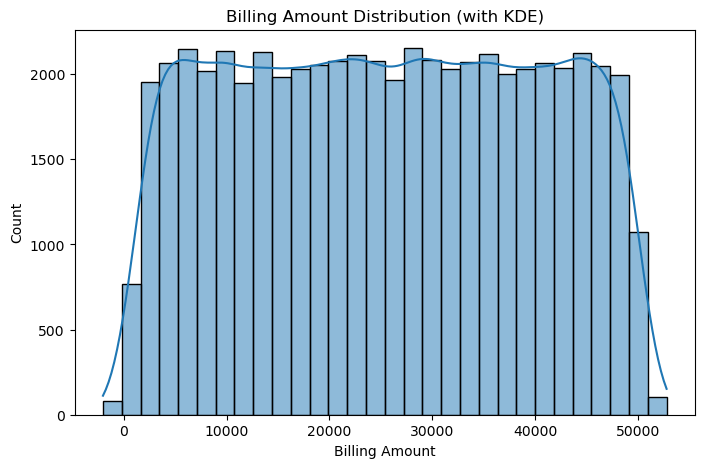

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df["billing_amount"], bins=30, kde=True)
plt.title("Billing Amount Distribution (with KDE)")
plt.xlabel("Billing Amount")
plt.ylabel("Count")
plt.show()


The billing amount distribution appears relatively uniform across the observed range, with no strong skewness. The KDE curve suggests a fairly even spread of billing values.


In [ ]:
#Billing by admission type
plt.figure()
df.boxplot(column="billing_amount", by="admission_type")
plt.title("Billing Amount by Admission Type")
plt.suptitle("")
plt.xlabel("Admission Type")
plt.ylabel("Billing Amount")
plt.show()


The box plot compares the distribution of billing amounts across Elective, Emergency, and Urgent admissions.
Across all admission types, the median billing amounts are very similar, indicating that typical costs do not differ substantially by admission category. The interquartile ranges are also comparable, suggesting a similar spread in the middle 50% of billing values.


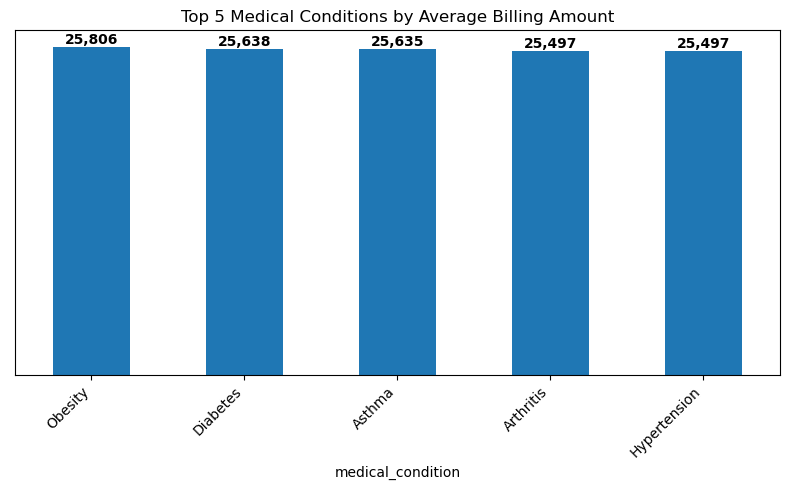

In [17]:
import matplotlib.pyplot as plt
avg_bill_condition = (
    df.groupby("medical_condition")["billing_amount"]
      .mean()
      .sort_values(ascending=False)
      .head(5)
)

plt.figure(figsize=(8,5))
ax = avg_bill_condition.plot(kind="bar")
ax.yaxis.set_visible(False)
for i, value in enumerate(avg_bill_condition):
    ax.text(
        i,
        value,
        f"{value:,.0f}",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

plt.title("Top 5 Medical Conditions by Average Billing Amount")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


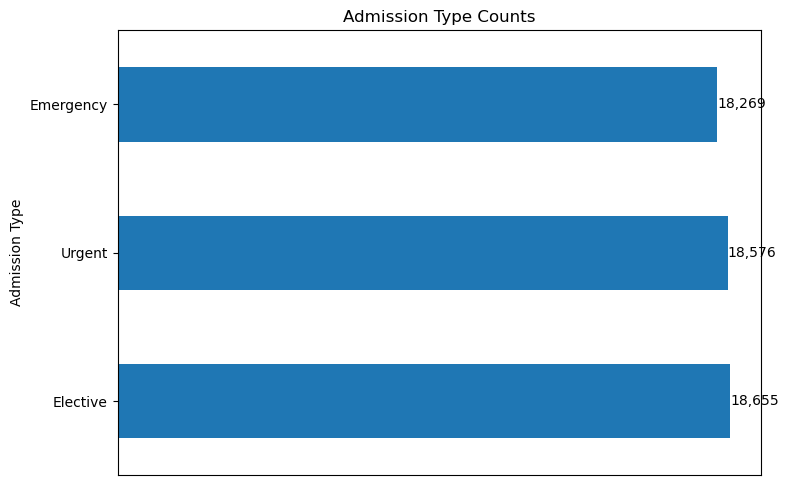

In [19]:
plt.figure(figsize=(8,5))

counts = df["admission_type"].value_counts()

ax = counts.plot(kind="barh")

plt.title("Admission Type Counts")
plt.xlabel("Number of Patients")
plt.ylabel("Admission Type")

# Add data labels
for i, value in enumerate(counts):
    ax.text(
        value,
        i,
        f"{value:,}",
        va="center",
        ha="left"plt.figure(figsize=(8,5))

counts = df["admission_type"].value_counts()

ax = counts.plot(kind="barh")

plt.title("Admission Type Counts")
plt.xlabel("Number of Patients")
plt.ylabel("Admission Type")

# Add labels INSIDE the bars
for i, value in enumerate(counts):
    ax.text(
        value * 0.98,   # slightly inside the bar
        i,
        f"{value:,}",
        va="center",
        ha="right",
        color="white",
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

    )
ax.xaxis.set_visible(False)

plt.tight_layout()
plt.show()


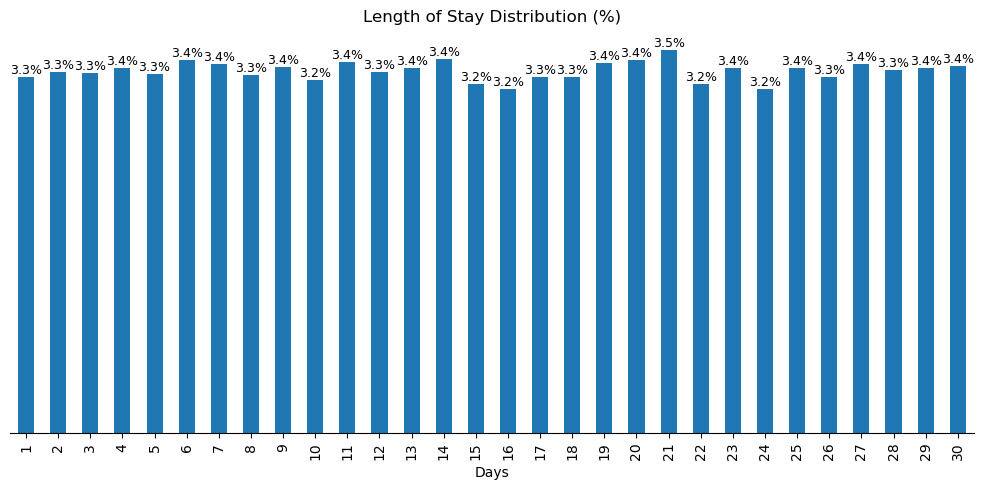

In [78]:
import matplotlib.pyplot as plt

# Count stays per day
los_counts = df['length_of_stay'].value_counts().sort_index()

# Convert to percentages
los_pct = los_counts / los_counts.sum() * 100

ax = los_pct.plot(kind='bar', figsize=(10,5))

# Add percentage labels
for i, v in enumerate(los_pct):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)

ax.set_title("Length of Stay Distribution (%)")
ax.set_xlabel("Days")
ax.set_ylabel("Percentage of Patients (%)")

ax.yaxis.set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()



No single length of stay dominates the distribution; patient stays are spread relatively evenly across durations, with each day accounting for a small percentage of total admissions.

In [23]:
# Create abnormal flag from test_results
df["is_abnormal"] = df["test_results"].str.lower().eq("abnormal")

df["is_abnormal"].value_counts()



False    36873
True     18627
Name: is_abnormal, dtype: int64

In [24]:
abnormal_rate = df["is_abnormal"].mean() * 100
abnormal_rate


33.56216216216216

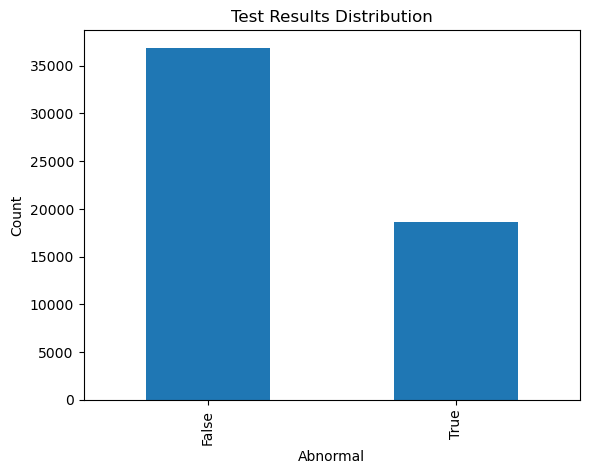

In [25]:
plt.figure()
df["is_abnormal"].value_counts().plot(kind="bar")
plt.title("Test Results Distribution")
plt.xlabel("Abnormal")
plt.ylabel("Count")
plt.show()


The majority of test results are normal, indicating that most patients do not exhibit abnormal findings. Abnormal test results occur less frequently but still represent a substantial portion of the data.
Overall, the distribution is clearly imbalanced, with normal outcomes predominating. This imbalance should be considered in downstream analysis or modeling, as abnormal results represent a minority class.


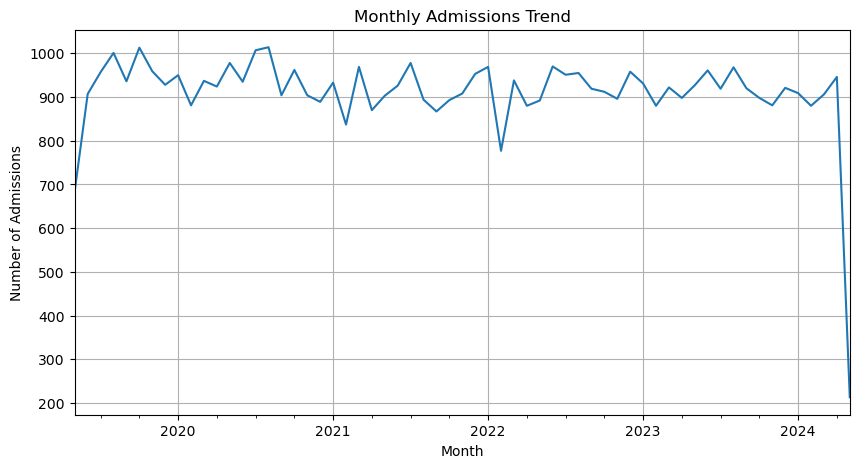

In [58]:
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])
df['admission_month'] = df['date_of_admission'].dt.to_period('M')
import matplotlib.pyplot as plt

monthly_admissions = df.groupby('admission_month').size()

plt.figure(figsize=(10,5))
monthly_admissions.plot()
plt.title("Monthly Admissions Trend")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.grid(True)
plt.show()



Overall, admissions remain relatively stable across the observed period, generally fluctuating between approximately 850 and 1,000 admissions per month. While there are short-term increases and decreases, there is no strong upward or downward long-term trend.
A noticeable dip occurs around early 2022, followed by a quick recovery in subsequent months. This suggests a temporary disruption rather than a sustained change in admission volume.
Overall, the chart indicates consistent patient inflow over time, with normal month-to-month variability.


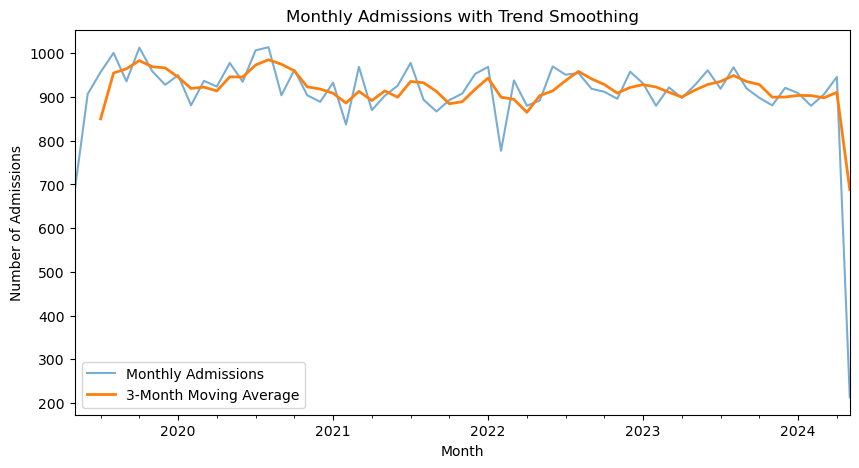

In [34]:
monthly_admissions_ma = monthly_admissions.rolling(3).mean()

plt.figure(figsize=(10,5))
monthly_admissions.plot(label='Monthly Admissions', alpha=0.6)
monthly_admissions_ma.plot(label='3-Month Moving Average', linewidth=2)
plt.legend()
plt.title("Monthly Admissions with Trend Smoothing")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.show()


This line chart displays monthly hospital admissions over time along with a 3-month moving average to smooth short-term fluctuations.
The raw monthly admissions show noticeable month-to-month variability, but values generally remain within a consistent range. The 3-month moving average highlights the underlying trend, which appears largely stable throughout the study period.
There is no evidence of sustained long-term growth or decline in admissions. A brief dip around early 2022 is visible, followed by a recovery, suggesting a temporary disruption rather than a structural change.
Overall, trend smoothing confirms that patient admissions remain steady over time, with only minor short-term variations.

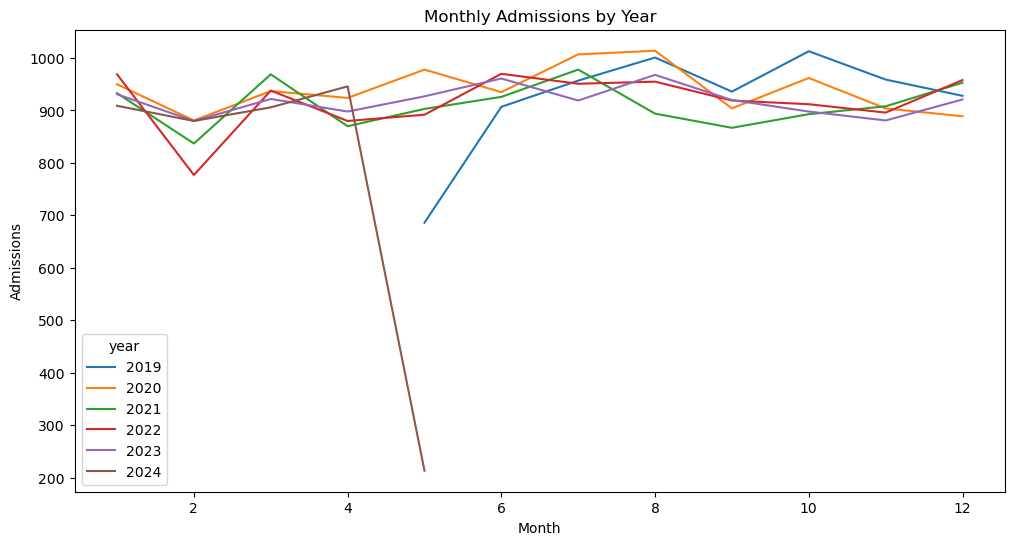

In [60]:
df['year'] = df['date_of_admission'].dt.year
df['month'] = df['date_of_admission'].dt.month

year_month = df.groupby(['year', 'month']).size().unstack()

year_month.T.plot(figsize=(12,6))
plt.title("Monthly Admissions by Year")
plt.xlabel("Month")
plt.ylabel("Admissions")
plt.show()


Most years show their highest admissions between July and August, suggesting increased demand during this period.
Aside from one anomaly, the monthly trends closely track each other, indicating stable year-over-year seasonality.

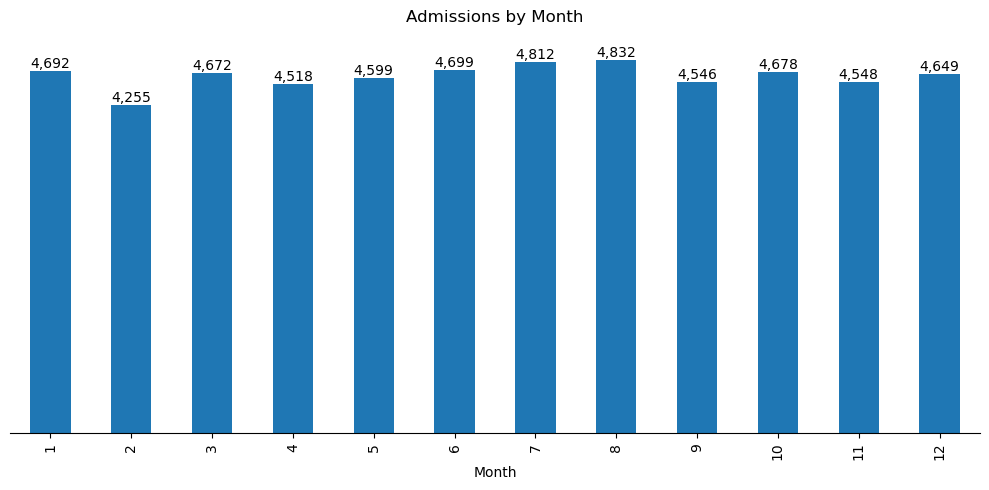

In [72]:
import matplotlib.pyplot as plt

seasonality = df.groupby(df['date_of_admission'].dt.month).size()

ax = seasonality.plot(kind='bar', figsize=(10,5))
ax.yaxis.set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
for i, v in enumerate(seasonality):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=10)

ax.set_title("Admissions by Month")
ax.set_xlabel("Month")

ax.set_ylim(0, max(seasonality) * 1.08)

plt.tight_layout()
plt.show()



Admissions remain relatively consistent throughout the year, with monthly totals ranging from approximately 4,250 to 4,830. The highest admission volumes occur in mid-year (around July and August), while slightly lower volumes are observed in February and early autumn.
Overall, the variation across months is modest, indicating no strong seasonal pattern in admissions. Patient volume appears stable across the year with only minor month-to-month fluctuations.


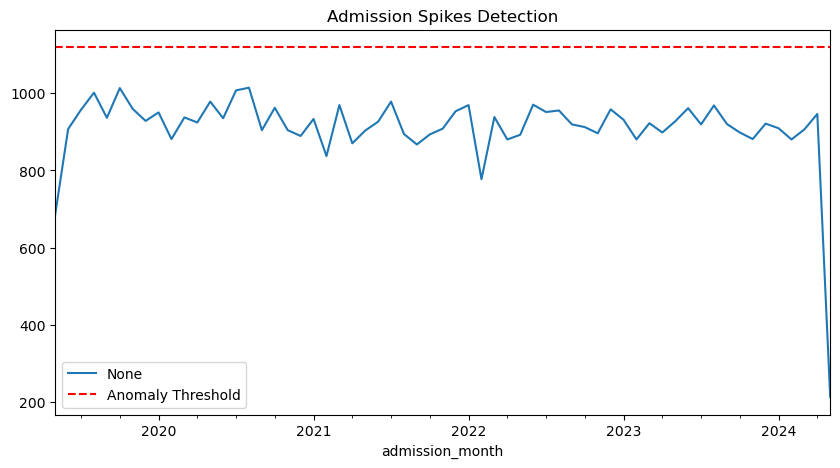

In [62]:
threshold = monthly_admissions.mean() + 2 * monthly_admissions.std()

plt.figure(figsize=(10,5))
monthly_admissions.plot()
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.title("Admission Spikes Detection")
plt.show()


The solid line represents observed monthly admissions, while the dashed horizontal line indicates the anomaly threshold, defined as the mean plus two standard deviations. This threshold represents an upper bound beyond which admission volumes would be considered unusually high.
Throughout the observed period, monthly admissions consistently remain below the anomaly threshold. Although short-term fluctuations are present, none exceed the defined limit, indicating the absence of extreme admission spikes.
Overall, the results suggest stable admission volumes with no statistically significant anomalies. This implies that operational planning should focus on managing routine variability rather than preparing for rare surge events.


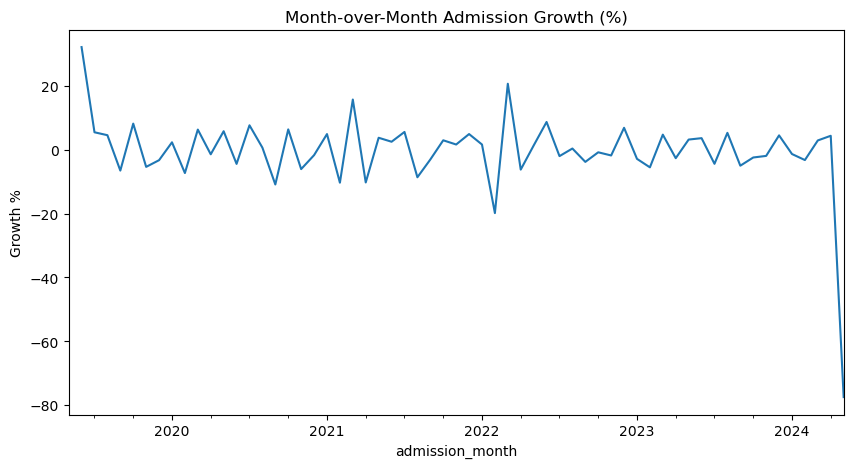

In [63]:
growth = monthly_admissions.pct_change() * 100

growth.plot(figsize=(10,5))
plt.title("Month-over-Month Admission Growth (%)")
plt.ylabel("Growth %")
plt.show()


Most month-over-month growth rates fluctuate close to zero, indicating relatively stable admission volumes over time. Both positive and negative changes occur, reflecting normal short-term variability rather than sustained growth or decline.
A notable negative spike appears around early 2022, indicating a sharp temporary decrease in admissions, followed by a rebound in subsequent months. Similarly, occasional positive spikes reflect short-term increases rather than long-term trends.
Overall, the growth pattern suggests that admissions remain stable over time, with no persistent upward or downward trajectory.

In [64]:
print("Peak month:", monthly_admissions.idxmax())
print("Lowest month:", monthly_admissions.idxmin())
print("Overall trend:", "Increasing" if monthly_admissions.iloc[-1] > monthly_admissions.iloc[0] else "Decreasing")


Peak month: 2020-08
Lowest month: 2024-05
Overall trend: Decreasing


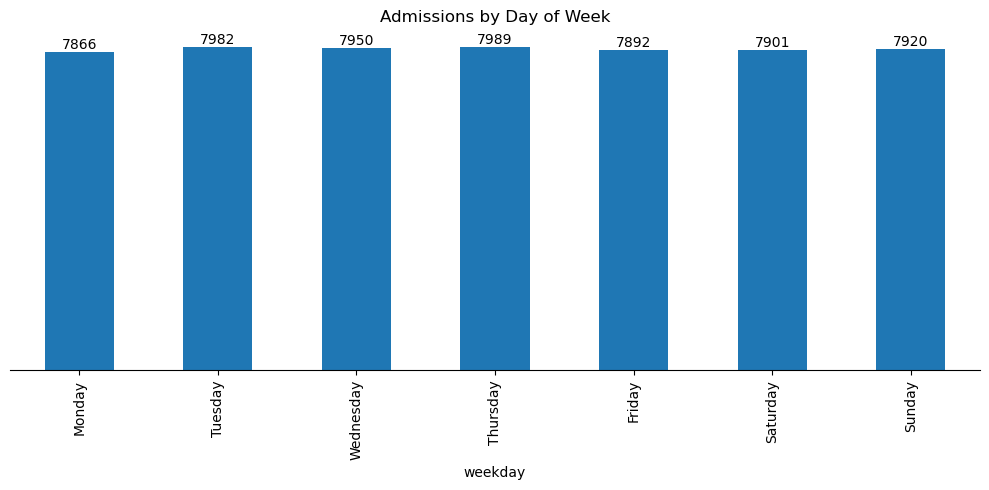

In [71]:
import matplotlib.pyplot as plt

counts = df.groupby('weekday').size().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)

ax = counts.plot(kind='bar', figsize=(10,5))

ax.yaxis.set_visible(False)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

for i, v in enumerate(counts):
    ax.text(i, v, f"{v}", ha='center', va='bottom', fontsize=10)

ax.set_title("Admissions by Day of Week")
plt.tight_layout()
plt.show()


Admissions remain consistent throughout the week with only marginal variation, indicating that weekday effects do not significantly influence admission volume.


In [66]:
before = df[df['date_of_admission'] < '2022-01-01'].shape[0]
after = df[df['date_of_admission'] >= '2022-01-01'].shape[0]

print("Before:", before)
print("After:", after)


Before: 29603
After: 25897


Forecasting Approach:
Exponential Smoothing was chosen due to its suitability for short-term trend forecasting without requiring extensive historical data.

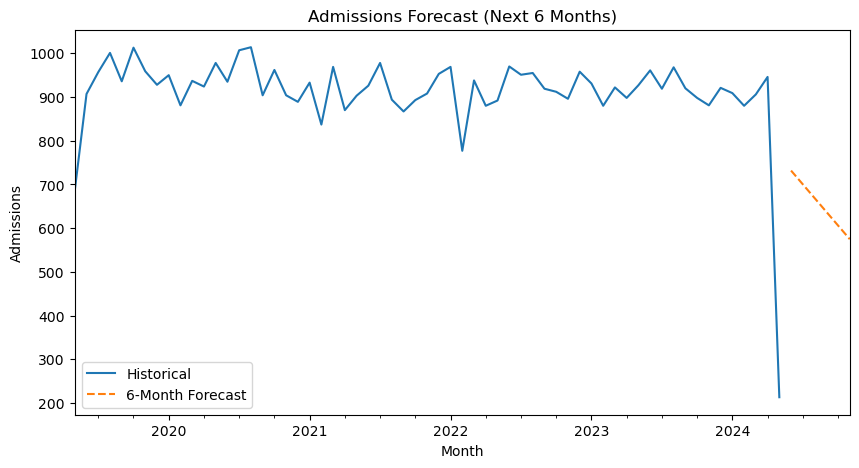

In [67]:
monthly_admissions = monthly_admissions.sort_index()
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(
    monthly_admissions,
    trend='add',
    seasonal=None
).fit()

forecast_6m = model.forecast(6)
plt.figure(figsize=(10,5))
monthly_admissions.plot(label='Historical')
forecast_6m.plot(label='6-Month Forecast', linestyle='--')
plt.legend()
plt.title("Admissions Forecast (Next 6 Months)")
plt.xlabel("Month")
plt.ylabel("Admissions")
plt.show()


This chart shows historical monthly hospital admissions along with a six-month forecast generated from the observed time series.
The historical data indicate relatively stable admissions with short-term fluctuations and no strong long-term upward trend. The forecasted values remain within a similar range to recent observations, suggesting continuity rather than a significant increase in admission volume.
The forecast reflects expected short-term variation rather than a pronounced growth pattern. As such, it should be interpreted as a baseline projection rather than a signal of increasing demand.
Overall, the forecast suggests that near-term capacity and staffing requirements are likely to remain similar to current levels, barring external shocks or structural changes.

In [68]:
forecast = model.forecast(6)
print("Expected peak capacity needed:", forecast.max())


Expected peak capacity needed: 731.6714208515574


In [69]:
summary = pd.DataFrame({
    "Metric": [
        "Total Admissions",
        "Average Monthly Admissions",
        "Peak Month",
        "Lowest Month"
    ],
    "Value": [
        len(df),
        round(monthly_admissions.mean(), 2),
        monthly_admissions.idxmax(),
        monthly_admissions.idxmin()
    ]
})

summary


,Metric,Value
0,Total Admissions,55500
1,Average Monthly Admissions,909.84
2,Peak Month,2020-08
3,Lowest Month,2024-05


Key Recommendations:

Increase weekday staffing, especially Mondays
Allocate resources to high-volume departments
Use rolling forecasts for short-term capacity planning
Monitor deviations from forecast as early warning signals

Assumption:

External factors like policy changes, pandemics are not explicitly modeled
Forecast is intended for short-term planning only
Data quality depends on source accuracy

Conclusion:

The analysis identified operational and seasonal drivers of hospital admissions, with weekday concentration and departmental imbalance. Forecasts suggest sustained demand growth, reinforcing the need for proactive resource planning.